## preprocessing the text

### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime
import pickle as pkl

In [2]:
from text_preprocessor import text_preprocessing, preprocess_line
from Transformer_model2 import transformer

### Tpu

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.105.174.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.105.174.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.105.174.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


In [4]:
CNF_DIR = '/content/drive/MyDrive/Data Science/AI_model_released/Transformer_chatbot'
current_time = str(datetime.datetime.now().strftime('%Y%m%d'))

### preprocess and tokenize data

In [5]:
lines_path = '/content/drive/MyDrive/Data Science/DataSet/TXT/Cornell Movie Dialogs/movie_lines.txt'
convs_path = '/content/drive/MyDrive/Data Science/DataSet/TXT/Cornell Movie Dialogs/movie_conversations.txt'

In [6]:
tokenizer, maxlen, questions_tensor, answers_tensor = text_preprocessing(lines_path,
                                                                         convs_path,
                                                                         30000,
                                                                         51)

size of lines list: 304,714
size of conversations list: 83,098
question size: 68,817 and answer size: 68,817


In [7]:
pkl.dump(tokenizer, open(os.path.join(CNF_DIR, f'tokenizer_{current_time}.cofig'), 'wb'))

In [8]:
questions_tensor.shape, answers_tensor.shape

((68817, 50), (68817, 50))

### hyperparameters

In [9]:
MAX_LENGTH = maxlen

# For tf.data.Dataset
BATCH_SIZE = int(64 * strategy.num_replicas_in_sync)
BUFFER_SIZE = questions_tensor.shape[0]

# For Transformer
NUM_LAYERS = 2 #6
D_MODEL = 512 #256
NUM_HEADS = 8
UNITS = 512 #2048
DROPOUT = 0.1
VOCAB_SIZE = len(tokenizer.word_index) + 1

EPOCHS = 50

In [10]:
config = {
    'vocab_size': VOCAB_SIZE,
    'maxlen': MAX_LENGTH,
    'batch_size': BATCH_SIZE,
    'buffer_size': BUFFER_SIZE,
    'num_layers': NUM_LAYERS,
    'd_model': D_MODEL,
    'num_heads': NUM_HEADS,
    'units': UNITS,
    'dropout': DROPOUT,
    'epochs': EPOCHS
}

pkl.dump(config, open(os.path.join(CNF_DIR, f'hyperparameters_{current_time}.cofig'), 'wb'))

### create a dataset

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_tensor[:],
        'dec_inputs': answers_tensor[:, :-1]
    },
    {
        'outputs': answers_tensor[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 50), dec_inputs: (None, 49)}, {outputs: (None, 49)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## Train the model

### loss function

In [12]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    real = tf.reshape(real, shape=(-1, MAX_LENGTH-1))

    loss = loss_obj(real, pred)
    
    mask = tf.cast(tf.not_equal(real, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [13]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

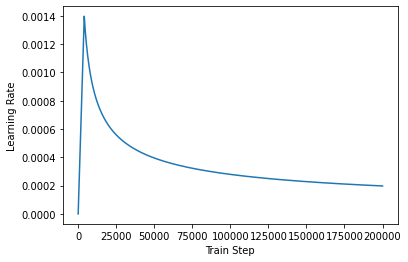

In [14]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Initialize and compile the transformer model

In [15]:
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(real, pred):
    real = tf.reshape(real, shape=(-1, MAX_LENGTH-1))

    return tf.keras.metrics.sparse_categorical_accuracy(real, pred)

In [16]:
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT
    )

    model.compile(optimizer=optimizer, loss=loss_function)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    20706304    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### callbacks

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [19]:
import datetime

#32% - 80 epok, po 30 epokach - 29

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.fit(dataset, epochs=EPOCHS, callbacks = [early_stop])

Epoch 1/50
135/135 [==============================] - 66s 261ms/step - loss: 0.6746
Epoch 2/50
135/135 [==============================] - 21s 153ms/step - loss: 0.6031
Epoch 3/50
135/135 [==============================] - 21s 152ms/step - loss: 0.5649
Epoch 4/50
135/135 [==============================] - 21s 152ms/step - loss: 0.5335
Epoch 5/50
135/135 [==============================] - 20s 150ms/step - loss: 0.5153
Epoch 6/50
135/135 [==============================] - 20s 150ms/step - loss: 0.5007
Epoch 7/50
135/135 [==============================] - 20s 149ms/step - loss: 0.4887
Epoch 8/50
135/135 [==============================] - 20s 148ms/step - loss: 0.4763
Epoch 9/50
135/135 [==============================] - 20s 148ms/step - loss: 0.4674
Epoch 10/50
135/135 [==============================] - 20s 149ms/step - loss: 0.4573
Epoch 11/50
135/135 [==============================] - 21s 153ms/step - loss: 0.4502
Epoch 12/50
135/135 [==============================] - 21s 153ms/step - lo

In [20]:
model.save_weights(f'{current_time}.h5')